# <font color='#28B463'>RIDGE REGRESSION

<br>

## <font color='#28B463'>Introduction

<br>
<b>Ridge Regression</b> (also known as Tikhonov regularization, or L2 regularization) <b>is the most commonly used method for regularization of ill-posed problems</b>.

<br>
An ill-posed problem is one which does not meet the three Hadamard criteria for being well-posed; mathematical models of physical phenomena should have all of the following properties :

<br>
<ul style="list-style-type:square">
    <li>
        a solution exists
    </li>    
    <li>
        the solution is unique
    </li>    
    <li>
        the solution behavior changes continuously with the initial conditions
    </li>    
</ul>

<br>
Under such circumstances, we will say that the problem is ill-posed or, equivalently, that the design matrix $\mathbf{X}$ is ill-conditioned. In the notebook regarding the violations of the CLMR assumptions we learned that, <b>in the context of linear regression, the main cause of ill-conditioning is multicollinearity</b>.

<br>
<blockquote style="background-color: #f0f0f5">
In the case of perfect multicollinearity, the design matrix $\mathbf{X}$ has less than full rank, and the matrix $\mathbf{X}^{\top}\mathbf{X}$ cannot be inverted; the ordinary least squares estimator $\boldsymbol{\hat{\beta}_{OLS}}$ does not exist.    
</blockquote>

<br>
<blockquote style="background-color: #f0f0f5">
In the case of non-perfect multicollinearity, the matrix $\mathbf{X}^{\top}\mathbf{X}$ actually has an inverse but a given computer algorithm may or may not be able to compute an approximate inverse. If it does so, the resulting matrix may be <b>highly sensitive to slight variations in the data, and may therefore be very inaccurate or very sample-dependent</b>. The design matrix $\mathbf{X}$ is said to be ill-conditioned, and the parameter vector $\boldsymbol{\beta}$ non-identifiable (for it has no unique solution).
</blockquote>

<br>
<blockquote style="background-color: #f0f0f5">
Another issue with multicollinearity is that <b>small changes to the input data can lead to large changes in the model</b>, even resulting in changes of sign of parameter estimates.
</blockquote>

<br>
Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity; when the latter occurs, least squares estimates are unbiased, but their variances are large so they may be far from the true value. <b>By adding a degree of bias to the regression estimates, ridge regression leads to a decrease in variance</b> (and hence in the prediction error), <b>yielding more reliable estimates</b>. 
   

<style>
body .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
</style>

## <font color='#28B463'>Problems with OLS

<br>
Ordinary least squares (under CLRM assumptions) provides estimates of the regression coefficients that are unbiased and have minimum variance in the class of the other linear unbiased estimators :


<br>
<blockquote style="background-color: #f0f0f5">
$
\begin{align}
    \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} 
    &= \newline
    &= (\mathbf{X}^{\top}\mathbf{X})^{-1} \mathbf{X}^{\top}\mathbf{Y} 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
        \text{the regressors have been standardized} \quad (\mathbf{X}^{\top}\mathbf{X} = \mathbf{R})
        \newline
    &= \mathbf{R}^{-1} \mathbf{X}^{\top}\mathbf{Y}
\end{align}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
\mathbf{E} \big[ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} \big] = \boldsymbol{\beta_{OLS}}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
\begin{align}
    \mathrm{V}(\hat{\boldsymbol{\beta}}_\boldsymbol{OLS}) 
    &= \newline
    &= \boldsymbol{\sigma^2} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
        \text{the regressand too has been standardized} \quad (\boldsymbol{\sigma^2} = 1)
        \newline
    &= \mathbf{R}^{-1}
\end{align}
$
</blockquote>

<br>
This estimation procedure yields reliable estimates if $\ (\mathbf{X}^{\top}\mathbf{X}) \ $, when in the form of a correlation
matrix, is nearly a unit (identity) matrix. 

<br>
In the presence of multicollinearity, however, if $ \ (\mathbf{X}^{\top}\mathbf{X}) \ $ is not nearly a unit matrix and we are forced to treat the estimated regression function as a black box (multicollinearity does not reduce the predictive power or reliability of the model as a whole, it only affects calculations regarding individual predictors) or to drop regressors in order to prevent the issue. Both these alternatives are unsatisfactory if the original intent was to use the estimated predictor for control and optimization. 


In [1]:
# SETUP : importing

import numpy as np
import math
import pandas as pd

from sklearn.datasets import load_boston

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

import sklearn.linear_model as lm
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as mtr
from scipy import stats

import utilcompute as uc
import utilplot as up
import preprocessing as pre
import regularized_regression as rr

from pprint import pprint


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM',    # per capita crime rate by town
    'ZN',      # proportion of residential land zoned for lots over 25,000 sq.ft.
    'INDUS',   # proportion of non-retail business acres per town
    'CHAS',    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    'NOX',     # nitric oxides concentration (parts per 10 million)
    'RM',      # average number of rooms per dwelling
    'AGE',     # proportion of owner-occupied units built prior to 1940
    'DIS',     # weighted distances to five Boston employment centres
    'RAD',     # index of accessibility to radial highways
    'TAX',     # full-value property-tax rate per $10,000
    'PTRATIO', # pupil-teacher ratio by town
    'B',       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    'LSTAT',   # % lower status of the population
    'MEDV'     # median value of owner-occupied homes in $1000's
]


In [3]:
# SETUP : printing aggregated info

#s = uc.summary(df)
#print(s)

In [4]:
target = 'MEDV'

if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [5]:
#fig, axs = plt.subplots(nrows = len(features), ncols = 1, figsize=(20, 4 * len(features)))    

#for (f_index, f) in enumerate(features) :
#    ax = axs[f_index]
#    subset = df[f]        
#    sns.distplot(a= subset, ax = ax, label = f)   
#    ax.axvline(x = subset.mean(), linestyle='--')
#    ax.legend(loc='best') 

#plt.tight_layout()
#plt.show()

In [6]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [7]:
# SETUP : data split

train_perc = 0.8
delimiter = int(len(df) * train_perc)

df_train = pd.DataFrame( df[:delimiter] ) # train + validation
df_test = pd.DataFrame( df[delimiter:] )  # test


## <font color='#28B463'>Assumptions

<br>
The assumptions are the same as those used in regular multiple regression: linearity, homoscedasticity, and independence. Since ridge regression does not provide confidence limits, normality need not be assumed.


## <font color='#28B463'>Standardization

<br>
In ridge regression, the first step is to standardize the variables (both dependent and independent) by subtracting
their means and dividing by their standard deviations :

<br>
$
    \quad
    \boldsymbol{X_i}^{\star}  = \dfrac {\boldsymbol{X_i} – \mu_X} {\sigma_X}
$

<br>
This would cause a change in notation, since we should indicate whether the variables in a particular formula are standardized or not; to keep things simple, in this notebook we will make the following general statement and then forget about notation.

<br>
As far as standardization is concerned, <b>all ridge regression calculations are based on standardized variables; when
the final regression coefficients are displayed, they are adjusted back into their original scale</b>. The ridge trace, however, is in a standardized scale.

In [8]:
# DATA PREPROCESSING (TRAIN + VALIDATION) : features transformation

#df_sk = pd.DataFrame()
#for (f_index, f) in enumerate(features):
#    subset = df_train[f]
#    log_modulus_transform = np.sign(subset) * np.log10(np.abs(subset) + 1)
#    if (abs(stats.skew(log_modulus_transform)) < abs(stats.skew(subset))) :
        #df_sk[f] = np.sqrt(df_train[f])
#        df_sk[f] = log_modulus_transform
#    else:
#        df_sk[f] = subset
#df_sk[target] =  df_train[target]

excluded_features = ['CHAS']
included_features = [f for f in features if (f not in excluded_features)]

#df_cnt = pre.center(df = df_sk, included = features, excluded = target)
#df_std = pre.standardize(df = df_sk, included = features, excluded = target)

df_cnt = pre.center(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std = pre.standardize(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))


In [9]:
# DATA PREPROCESSING (TEST) : features transformation

#df_sk_test = pd.DataFrame()
#for (f_index, f) in enumerate(features):
#    df_sk_test[f] = np.sqrt(df_test[f])
#df_sk_test[target] =  df_test[target]

#df_cnt_test = pre.center(df = df_sk_test, included = features, excluded = target)
#df_std_test = pre.standardize(df = df_sk_test, included = features, excluded = target)

df_cnt_test = pre.center(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std_test = pre.standardize(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))


### <font color='#28B463'>Impact on the transformed features

<br>

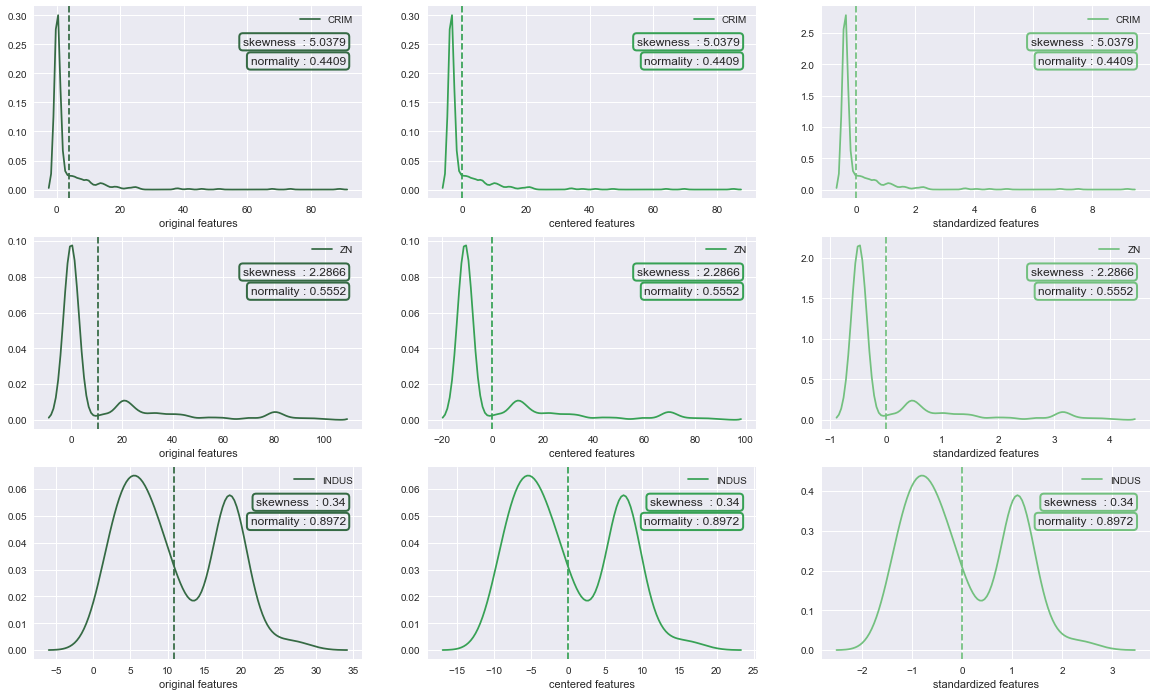

In [10]:
plot_list = [
    { 'df' : df_train, 'xlabel' : 'original features',     'legend_loc' : 'best'},
    #{ 'df' : df_sk,    'xlabel' : 'un-skewed features',    'legend_loc' : 'best'},
    { 'df' : df_cnt,   'xlabel' : 'centered features',     'legend_loc' : 'best'},
    { 'df' : df_std,   'xlabel' : 'standardized features', 'legend_loc' : 'best'}
]

visualized_features = included_features[:3]

n_rows = len(visualized_features)
n_cols = len(plot_list)
fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(20, 4 * n_rows ))    
pal = sns.color_palette("Greens_d", n_cols)

p = 0
for (pl_index, pl_dict) in enumerate(plot_list):      
    for (f_index,f) in enumerate(visualized_features) :
        ax = axs[f_index][pl_index] 
        subset = pl_dict['df'][f]       
        
        skewness = round(stats.skew(subset),4)
        normality = round(stats.shapiro(subset)[0],4)
        
        sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = f)   
        ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
        
        ax.text(x = 0.95, y = 0.8, horizontalalignment='right', s = ('skewness  : {0}'.format(skewness)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))
        ax.text(x = 0.95, y = 0.7, horizontalalignment='right', s = ('normality : {0}'.format(normality)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))        
        
        ax.set_xlabel(pl_dict['xlabel'])
        ax.legend(loc = pl_dict['legend_loc'])
    p += 1
        

#plt.tight_layout()
plt.show()


### <font color='#28B463'>Impact on the VIF

<br>

In [11]:
vif_list = [
    {'df' : df_train, 'features' : features, 'label' : 'original'},
    {'df' : df_cnt,   'features' : features, 'label' : 'centered'},
    {'df' : df_std,   'features' : features, 'label' : 'standardized'}
]

template = "{0:<20}:{1:>10}" 
   
for vl in vif_list:    
    vif_dict = uc.compute_vif(df = vl['df'], features = vl['features'])
    print('VIF ({0})'.format(vl['label']))
    print()
    for (key, value) in vif_dict.items():
        print(template.format(key, round(value,4)))
    print()
    print()


VIF (original)

CRIM                :    2.0418
ZN                  :    3.0296
INDUS               :   15.5406
CHAS                :    1.1574
NOX                 :   77.0569
RM                  :   74.3479
AGE                 :   21.0854
DIS                 :   15.0748
RAD                 :    15.361
TAX                 :   65.6476
PTRATIO             :   85.5914
B                   :   19.3088
LSTAT               :   11.3059


VIF (centered)

CRIM                :    1.7513
ZN                  :     2.456
INDUS               :    4.3122
CHAS                :    1.0798
NOX                 :    4.4764
RM                  :    1.9463
AGE                 :    2.9617
DIS                 :    4.0246
RAD                 :     7.678
TAX                 :    9.6658
PTRATIO             :    1.8491
B                   :     1.345
LSTAT               :    3.0057


VIF (standardized)

CRIM                :    1.7513
ZN                  :     2.456
INDUS               :    4.3122
CHAS            

In [12]:
linear_list = [
    { 'df' : df_train,     'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'original' },
    #{ 'df' : df_sk,     'linear_model_name' : 'LinearRegression', 
    # 'linear_model_args' : {'fit_intercept' : True}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'centered' },
    { 'df' : df_std, 'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'standardized'}    
]

results = pd.DataFrame()

for l in linear_list:
    results_temp = uc.compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        linear_model_name = l['linear_model_name'], 
        linear_model_args = l['linear_model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results = results.append(results_temp).reset_index(drop = True)

#print(results[['note','intercept', 'err_test']])

## <font color='#28B463'>Derivation

<br>
From the previous notebooks we know that the coefficients estimates are found by minimizing a so-called objective (or cost) function; here a comparison of this cost function in the context of OLS (residual sum of squares) and Ridge Regression (penalized sum of squares) :


<br>
<blockquote style="background-color: #f0f0f5">
$
    \begin{align}
        S_{OLS}(\hat{\boldsymbol{\beta}}) 
        &= 
        \newline
        &= \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}
        \newline
        &= (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})^{T} (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})            
    \end{align}
$
</blockquote>

<br>
$
    \qquad \quad
    \begin{align}
        S_{R}(\hat{\boldsymbol{\beta}})    
        &= 
        \newline
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            \quad \text{subject to } \quad \sum _{i=1}^{p}{\boldsymbol{\beta_j}^2} \leq t
        \newline        
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            + \boldsymbol{k} \sum _{j=1}^{p} {\hat{\boldsymbol{\beta}}_\boldsymbol{j}}^{2}
        \newline
        &= 
            \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}
            + \boldsymbol{k} \sum _{j=1}^{p} {\hat{\boldsymbol{\beta}}_\boldsymbol{j}}^{2}
        \newline
        &= 
            (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})^{T} (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})  
            + \boldsymbol{k} \ ( \ \hat{\boldsymbol{\beta}}^{\top}\hat{\boldsymbol{\beta}} \ )
    \end{align}
$


<br>
<blockquote style="background-color: #f0f0f5">
$
    \quad
    \begin{align}
        \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}
        &=
        \newline
        &= {\rm {arg}}\min _{\hat{\beta} \in \mathbb{R}^{p}} S_{OLS}(\hat{\boldsymbol{\beta}})
        \newline \newline
        &=  {\rm {arg}}\min _{\hat{\beta} \in \mathbb{R}^{p}} 
            \left[ 
                \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2} 
            \right]
            \quad = \quad
            \left({\dfrac {1}{n}}\sum_{i=1}^{n} \mathbf{X}_{i}\mathbf{X}_{i}^{\top}\right)^{\!-1}\!\!\cdot \,
            {\dfrac {1}{n}}\sum _{i=1}^{n}\mathbf{X}_{i}\mathbf{Y}_{i}
        \newline \newline
        &=  {\rm {arg}}\min _{\hat{\beta} \in \mathbb{R}^{p}}
            \left[ 
                (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})^{T} (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}}) 
            \right]
            \quad = \quad (\mathbf{X}^{\top}\mathbf{X})^{-1} \mathbf{X}^{\top}\mathbf{Y} 
            \quad = \quad \mathbf{R}^{-1} \mathbf{X}^{\top}\mathbf{Y} 
    \end{align}
$
</blockquote>

$
    \qquad \qquad
    \begin{align}
        \hat{\boldsymbol{\beta}}_\boldsymbol{R}
        &= 
        \newline
        &= {\rm {arg}}\min _{\hat{\beta} \in \mathbb{R}^{p}} S_{R}(\hat{\boldsymbol{\beta}})
        \newline \newline
        &=  {\rm {arg}}\min _{\hat{\beta} \in \mathbb{R}^{p}} 
            \left[ 
                \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}
                + \boldsymbol{k} \sum _{j=1}^{p} {\hat{\boldsymbol{\beta}}_\boldsymbol{j}}^{2}
            \right]   
            \quad = \quad 
        \newline
        &=  {\rm {arg}}\min _{\hat{\beta} \in \mathbb{R}^{p}} 
            \left[ 
                (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})^{T} 
                (\mathbf{Y} - \mathbf{X} \hat{\boldsymbol{\beta}})  
                + \boldsymbol{k} \ ( \ \hat{\boldsymbol{\beta}}^{\top}\hat{\boldsymbol{\beta}} \ )
            \right]
            \quad = \quad 
            \big[ \mathbf{X}^{\top} \mathbf{X} + \boldsymbol{k} \ \mathbf{I} \big]^{-1} \ \mathbf{X}^{\top} \mathbf{Y}
            \quad = \quad 
            \big[ \mathbf{R} + \boldsymbol{k} \ \mathbf{I} \big]^{-1} \ \mathbf{X}^{\top} \mathbf{Y}
    \end{align}
$

<br>
Just like we saw with OLS, the derivation of the ridge estimator is performed in two stages :

<ul style="list-style-type:square">
    <li>
        <b>stage 1</b> consists of determining the first-order conditions (FOC, also known as normal equations) for minimizing
        the penalized residual sum of squares function PRSS;
    </li>
    <br>
    <li>
        <b>stage 2</b> consists of solving the normal equations in order to obtain the explicit expressions for the 
        estimators
    </li>
</ul>

<br>
<font color='#28B463'><b>Partial Differentiation</b></font>

<br>
$
    \quad
    \begin{align}
        \dfrac
            {\partial \ PRSS}
            {\partial \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} }
        &= 
        \newline
        &=
            \dfrac
                {\partial \ RSS}
                {\partial \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} }
            + \dfrac
                {\partial \ \text{penalty term}}
                {\partial \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} }
        \newline
        &= 
            - 2 \ \mathbf{X}^{\top} \mathbf{Y}
            + 2 \ \mathbf{X}^{\top} \mathbf{X} \ \hat{\boldsymbol{\beta}}_\boldsymbol{R}      
            + 2 \ \lambda \ \hat{\boldsymbol{\beta}}_\boldsymbol{R}     
    \end{align}     
$

<br>
<font color='#28B463'><b>Solving the normal equations</b></font>

<br>
$
    \quad
    \begin{align}
        & \qquad
            - 2 \mathbf{X}^{\top} \mathbf{Y}
            + 2 \mathbf{X}^{\top} \mathbf{X} \ \hat{\boldsymbol{\beta}}_\boldsymbol{R}      
            + 2 \ \lambda \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} = 0
        \newline
        \Rightarrow & \qquad
            \hat{\boldsymbol{\beta}}_\boldsymbol{R} \left( \mathbf{X}^{\top} \mathbf{X} + \lambda \ \mathbf{I} \right)
            = \mathbf{X}^{\top} \mathbf{Y}
        \newline
        \Rightarrow & \qquad
            \hat{\boldsymbol{\beta}}_\boldsymbol{R}
            = \big[ \mathbf{X}^{\top} \mathbf{X} + \lambda \ \mathbf{I} \big]^{-1} \ \mathbf{X}^{\top} \mathbf{Y}
    \end{align}
$

## <font color='#28B463'>Geometric interpretation

<br>
For any $ \ \boldsymbol{k} \ $ and corresponding solution in the previous formulation (sometimes called penalized form) there is a value of $ \ \boldsymbol{t} \ $ such that we obtain the same solution in the constrained form (one-to-one relationship between the two regularization parameters).

<br>
Constrained estimators force the coefficients vector to lie in a geometric shape centered around the origin; the shape of the constrain region is defined by the type of norm we use as penalty. The most commonly used norms are the p-norms, which have the following character :

<br>
$
    \quad
    {\lVert \ \hat{\boldsymbol{\beta}} \ \rVert}_P
    = \left( \ \sum _{j=1}^{p} {\mid \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} \ \mid}^{1/P} \ \right)
    \qquad \text{where} \ P \ \text{defines the P-norm, while} \ p \ \text{(as usual) is the number of features}
$

<br>
Ridge regression deploys L2-norm (also called Euclidean norm); in comparison, OLS solves the unconstrained least squares problem.

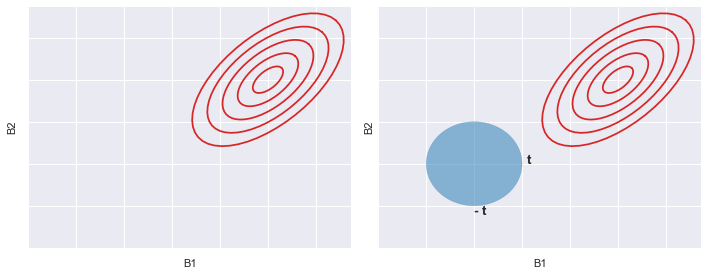

In [13]:
rr.plot_constrain_regions(cmd = 'ols_vs_ridge')

## <font color='#28B463'>Ridge Estimator

<br>
Ridge regression proceeds by adding a small positive value $\lambda$ (usually less than 1) to the diagonal elements of the correlation matrix; for any design matrix $\mathbf{X}$, the quantity $(\mathbf{X}^{\top}\mathbf{X} + \lambda \mathbf{I})$
is always invertible and there will always be a unique solution for $\hat{\boldsymbol{\beta}}_\boldsymbol{R} $ :


<br>
$
    \quad
    \begin{align}
        \hat{\boldsymbol{\beta}}_\boldsymbol{R} 
        &= 
        \newline
        & = 
            \underbrace{ (\mathbf{R} + k \mathbf{I})^{-1} } _{ \mathbf{W} } \ \mathbf{X}^{\top}\mathbf{Y}     
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad & [\textbf{E1-A}] 
        \newline \newline
        &= \big[ \mathbf{R} \ (\mathbf{I} + k \mathbf{R}^{-1}) \big]^{-1} \mathbf{X}^{\top}\mathbf{Y} 
            & (AB)^{-1} = B^{-1} A^{-1}
        \newline
        &= \big[ \mathbf{I} + k \mathbf{R}^{-1} \big]^{-1} \mathbf{R}^{-1} \mathbf{X}^{\top}\mathbf{Y} 
        \newline
        &= 
            \underbrace{ \big[ \mathbf{I} + k \mathbf{R}^{-1} \big]^{-1} } _{ \mathbf{Z} } 
            \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}  
                & [\textbf{E1-B}] 
        \newline \newline
        &= \mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}  
            & [\textbf{E1-C}] 
    \end{align}
$

<br>
$
    \quad
    \begin{align}
        \mathbf{W} 
        &=
        \newline
        &= (\mathbf{R} + \lambda \mathbf{I})^{-1}
        \newline
        &= \big[ (\mathbf{I} + \lambda \mathbf{R}^{-1}) \mathbf{R} \big] ^{-1}
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad & (AB)^{-1} = B^{-1} A^{-1}            
        \newline
        &= \mathbf{R}^{-1} \ \big[ \mathbf{I} + \lambda \mathbf{R}^{-1} \big] ^{-1}
        \newline
        &= \mathbf{R}^{-1} \ \mathbf{Z}
            & [\textbf{E2-A}]
        \newline\newline
        \mathbf{Z} &= \mathbf{R} \ \mathbf{W} 
            & [\textbf{E2-B}]
    \end{align}   
$

It can be shown that <b>there exists a value of $\lambda$ for which the mean squared error (the variance plus the bias squared)
of the ridge estimator is less than that of the least squares estimator</b>. Unfortunately, the appropriate value of $\lambda$
depends on knowing the true regression coefficients (which are only being estimated) and an analytic solution has not
been found that guarantees the optimality of the ridge solution.

## <font color='#28B463'>Bias

<br>
We know that ridge estimation produces a biased estimator of the true parameters $\boldsymbol{\beta}$, but how large is this bias , and how does it behave ?

<br>
$
    \quad
    \begin{align}
        \mathbf{E} \big[ \hat{\boldsymbol{\beta}}_\boldsymbol{R} - \boldsymbol{\beta} \big] 
            &= & \text{by } \textbf{E1-B} 
            \newline
            &=  \mathbf{E} 
                \bigg[ 
                    \big( \mathbf{I} + \lambda \mathbf{R}^{-1} \big)^{-1} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}  
                \bigg] 
            \newline
            &= 
                \big[ \mathbf{I} + \lambda \mathbf{R}^{-1} \big]^{-1} \ 
                \mathbf{E} \big[ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} \big]
            \newline
            &=  \big[ \mathbf{I} + \lambda \mathbf{R}^{-1} \big]^{-1} \ \boldsymbol{\beta}
                \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
                \qquad \qquad \qquad \qquad \qquad \qquad \quad &  [\textbf{E3-A}] 
            \newline \newline
            &= \mathbf{Z} \ \boldsymbol{\beta}  
                &  [\textbf{E3-B}] 
            \newline \newline
            &= \big[ \mathbf{R}^{-1} \ \big(\mathbf{R} + \lambda \mathbf{I} \big) \big]^{-1} \ \boldsymbol{\beta}
                & (AB)^{-1} = B^{-1} A^{-1}
            \newline
            &= \big[ \mathbf{R} + \lambda \mathbf{I} \big]^{-1} \mathbf{R} \ \boldsymbol{\beta}
            \newline
            &= 
                \big[ \mathbf{R} + \lambda \mathbf{I} \big]^{-1} 
                \big[ \mathbf{R} + \lambda \mathbf{I} - \lambda \mathbf{I} \big]
                \ \boldsymbol{\beta}
            \newline
            &= \big[ \mathbf{I} - \lambda \big( \mathbf{R} + \lambda \mathbf{I} \big)^{-1} \big] \ \boldsymbol{\beta}
            \newline
            &= \boldsymbol{\beta} - \lambda \big( \mathbf{R} + \lambda \mathbf{I} \big)^{-1} \boldsymbol{\beta}
                & [\textbf{E3-C}] 
            \newline \newline
            &= \boldsymbol{\beta} - \lambda \mathbf{W} \boldsymbol{\beta}
                & [\textbf{E3-D}]
    \end{align}
$

<br>
As we may have expected, <b>the bias of the ridge estimator is proportional to $\lambda$ </b> :

<br>
<ul style="list-style-type:square">
    <li>
        for $\lambda = 0$, there is no regularization (or penalization, or bias) and the parameters estimated with ridge
        regression correspond to those estimated with ordinary least squares
    </li>
    <br>
    <li>
        for $\lambda > 0$ the ridge estimator is biased; the larger is $\lambda$, the larger is the bias of the ridge estimator
        with respect to true parameters $\boldsymbol{\beta}$
    </li> 
    <br>
    <li>
        for $\lambda \rightarrow \infty$ the penalization reaches its peak and all the estimated parameters converge to zero :
        $
            \lim_{\lambda \to \infty} \mathbf{E} \big[ \hat{\boldsymbol{\beta}}_\boldsymbol{R} \big] = 0 _{p x 1}
        $
    </li>
</ul>

## <font color='#28B463'>Variance

<br>
$
    \quad
    \begin{align}
        \mathrm{Var}(\hat{\boldsymbol{\beta}}_\boldsymbol{R}) 
            &= & \text{by } \textbf{E1-C} 
            \newline
            &= \mathrm{Var}( \mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} )
                \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
                \qquad \qquad \qquad \qquad \qquad \qquad \qquad  
                & \mathrm{Var} (\star \bullet) = \star \mathrm{Var} (\bullet) \star^{\top}
            \newline
            &= \mathbf{Z} \ \mathrm{V}( \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} ) \ \mathbf{Z}^{\top}
            \newline
            &= \mathbf{Z} \ \big[ \boldsymbol{\sigma^2} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} \big] \ \mathbf{Z}^{\top}
            \newline
            &= \boldsymbol{\sigma^2} \ \mathbf{Z} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} \ \mathbf{Z}^{\top}            
                &  [\textbf{E4}] 
    \end{align}
$

<br>
Just like the expected value, <b>the variance of the coefficients estimated</b> through ridge regression <b>decreases towards zero as the regularization hyper-parameter $\lambda$ becomes large, asymptotically converging to zero </b>:

<br>
$
    \quad
    \lim_{\lambda \to \infty} \mathrm{Var}(\hat{\boldsymbol{\beta}}_\boldsymbol{R}) = 0 _{p x p}
$

<br>
Now that we have an explicit expression of the variance of the ridge estimator, we can compare it to that of the OLS estimator :

<br>
$
    \quad
    \begin{align}
        \mathrm{Var}(\hat{\boldsymbol{\beta}}_\boldsymbol{OLS}) - \mathrm{Var}(\hat{\boldsymbol{\beta}}_\boldsymbol{R})
        &= 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
            & \text{by } \textbf{E4} 
        \newline
        &=  
            \boldsymbol{\sigma^2} \ (\mathbf{X}^{\top}\mathbf{X})^{-1}
            - \boldsymbol{\sigma^2} \ \mathbf{Z} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} \ \mathbf{Z}^{\top}            
        \newline
        &=  \boldsymbol{\sigma^2} \ 
            \big[ \mathbf{R}^{-1} - \mathbf{Z} \ \mathbf{R}^{-1} \ \mathbf{Z}^{\top} \big]
            &  [\textbf{E5}] 
        \newline
        &=  \boldsymbol{\sigma^2} \ \mathbf{Z} \ 
            \left[
                 \mathbf{Z}^{-1} \ \mathbf{R}^{-1}                                  \ {\mathbf{Z}^{\top}}^{-1} 
               - \mathbf{Z}^{-1} \ \mathbf{Z} \ \mathbf{R}^{-1} \ \mathbf{Z}^{\top} \ {\mathbf{Z}^{\top}}^{-1}
            \right] \ \mathbf{Z}^{\top}
    \end{align}
$

## <font color='#28B463'>MSE Decomposition

<br>
In order to look at $ \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} \ $ from the point of view of mean square error it is necessary to obtain an expression for the distance between the estimates and the true regression coefficients; the straightforward application of the expectation operator gives the following :


<br>
$
    \quad
    \begin{align}
        \operatorname{MSE}(\hat{\boldsymbol{\beta}}_\boldsymbol{R})
        &=
        \newline
        &=  \mathbf{E} 
            \left[ \ 
                (\hat{\boldsymbol{\beta}}_\boldsymbol{R} - \boldsymbol{\beta})^{\top} 
                (\hat{\boldsymbol{\beta}}_\boldsymbol{R} - \boldsymbol{\beta}) 
            \ \right] 
        \newline
        &=  \mathbf{E} 
            \left[ \ 
                (\mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} - \boldsymbol{\beta})^{\top} 
                (\mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} - \boldsymbol{\beta}) 
            \ \right] 
        \newline
        &=  \mathbf{E} 
            \left[ \ 
                (\hat{\boldsymbol{\beta}}_\boldsymbol{OLS}^{\top} \ \mathbf{Z}^{\top} - \boldsymbol{\beta}^{\top})
                (\mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} - \boldsymbol{\beta}) 
            \ \right] 
        \newline
        &=  
            \mathbf{E} 
            \left[ \ 
                \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}^{\top} \ \mathbf{Z}^{\top}
                \ \mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}
                \quad - \quad \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}^{\top} \ \mathbf{Z}^{\top} \ \boldsymbol{\beta}
                \quad - \quad \boldsymbol{\beta}^{\top} \ \mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}
                \quad + \quad \boldsymbol{\beta}^{\top} \ \boldsymbol{\beta}
            \ \right]
    \end{align}
$

$
    \quad
    \begin{align*}
        \qquad \quad \;
        &=  
        \newline
        &   \quad
            \begin{aligned}[T]           
                &
                \ \mathbf{E} 
                \left[ \ 
                    \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}^{\top} \ \mathbf{Z}^{\top}
                    \ \mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}
                    \quad - \quad \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}^{\top} \ \mathbf{Z}^{\top} \ \boldsymbol{\beta}
                    \quad - \quad \boldsymbol{\beta}^{\top} \ \mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}
                    \quad + \quad \boldsymbol{\beta}^{\top} \ \boldsymbol{\beta}
                \ \right]
                \newline
                + \ &
                \ \mathbf{E} 
                \left[ \ 
                    - \boldsymbol{\beta}^{\top} \ \mathbf{Z}^{\top} \mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}
                    \quad - \quad 
                    \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}^{\top} \ \mathbf{Z}^{\top} \mathbf{Z} \ \boldsymbol{\beta}
                    \quad + \quad 
                    \boldsymbol{\beta}^{\top} \ \mathbf{Z}^{\top} \mathbf{Z} \ \boldsymbol{\beta}                
                \ \right]
                \newline
                + \ &
                \ \mathbf{E} 
                \left[ \ 
                    + \boldsymbol{\beta}^{\top} \ \mathbf{Z}^{\top} \mathbf{Z} \ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}
                    \quad + \quad 
                    \hat{\boldsymbol{\beta}}_\boldsymbol{OLS}^{\top} \mathbf{Z}^{\top} \mathbf{Z} \ \boldsymbol{\beta}
                    \quad - \quad 
                    \boldsymbol{\beta}^{\top} \ \mathbf{Z}^{\top} \mathbf{Z} \ \boldsymbol{\beta}                
                \ \right]
            \end{aligned}
    \end{align*}
$

$
    \quad
    \begin{align*}
        \qquad \quad \;
        &=  
        \newline
        & \quad
            \begin{aligned}[T]  
            &
            \ \mathbf{E} 
            \left[ \ 
                (\hat{\boldsymbol{\beta}}_\boldsymbol{OLS} - \boldsymbol{\beta})^{\top} 
                \ \mathbf{Z}^{\top} \mathbf{Z}
                \ (\hat{\boldsymbol{\beta}}_\boldsymbol{OLS} - \boldsymbol{\beta}) 
            \ \right] 
            \newline
            - & \
            \left[ \
                              \boldsymbol{\beta}^{\top} \ \mathbf{Z}^{\top} \mathbf{Z} \ \boldsymbol{\beta}
                \quad + \quad \boldsymbol{\beta}^{\top} \ \mathbf{Z}^{\top} \mathbf{Z} \ \boldsymbol{\beta}
                \quad + \quad \boldsymbol{\beta}^{\top} \ \mathbf{Z}^{\top} \mathbf{Z} \ \boldsymbol{\beta}
                \quad - \quad \boldsymbol{\beta}^{\top} \ \mathbf{Z} \ \boldsymbol{\beta}
                \quad - \quad \boldsymbol{\beta}^{\top} \ \mathbf{Z}^{\top} \ \boldsymbol{\beta}
                \quad + \quad \boldsymbol{\beta}^{\top} \boldsymbol{\beta}
            \ \right]
            \end{aligned}
    \end{align*}
$

$
    \quad
    \begin{align}
        \newline
        \qquad \quad \;
        &= 
            \mathbf{E} 
            \left[ \ 
                (\hat{\boldsymbol{\beta}}_\boldsymbol{OLS} - \boldsymbol{\beta})^{\top} 
                \ \mathbf{Z}^{\top} \mathbf{Z}
                \ (\hat{\boldsymbol{\beta}}_\boldsymbol{OLS} - \boldsymbol{\beta}) 
            \ \right] 
            + (\mathbf{Z} \boldsymbol{\beta} - \boldsymbol{\beta})^{\top} (\mathbf{Z} \boldsymbol{\beta} - \boldsymbol{\beta}) 
        \newline
        &= 
            \mathbf{E} 
            \left[ \ 
                (\hat{\boldsymbol{\beta}}_\boldsymbol{OLS} - \boldsymbol{\beta})^{\top} 
                \ \mathbf{Z}^{\top} \mathbf{Z}
                \ (\hat{\boldsymbol{\beta}}_\boldsymbol{OLS} - \boldsymbol{\beta}) 
            \ \right] 
            + \boldsymbol{\beta}^{\top} (\mathbf{Z} - \mathbf{I})^{\top} (\mathbf{Z} - \mathbf{I}) \ \boldsymbol{\beta}
            \qquad \qquad \qquad 
            & \text{Mathai and Provost (1992) : if } \epsilon \sim \mathcal{N}(\mu_{\epsilon},\ {\sigma_{\epsilon}}^2)
        \newline
        &
            & \text{then } \mathbf{E}[ \ \epsilon^{\top} \Lambda \ \epsilon \ ] 
            = trace[ \ \Lambda \ {\sigma_{\epsilon}}^{2} \ ] + {\mu_{\epsilon}}^{\top} \Lambda \ \mu_{\epsilon}
        \newline
        &
            & \text{replacing } \epsilon \text{ with } 
            \hat{\boldsymbol{\beta}}_\boldsymbol{R} \sim \mathcal{N}(\boldsymbol{\beta},\ \sigma^2 \mathbf{R}^{-1})
        \newline \newline
        &= 
            trace \ [ \ \mathrm{Var}(\hat{\boldsymbol{\beta}}_\boldsymbol{R}) \ ]
            + {\lVert \ bias \ (\hat{\boldsymbol{\beta}}_\boldsymbol{R}) \ \rVert}^2
            & \text{by } \textbf{E4} 
        \newline
        &= 
            \boldsymbol{\sigma^2} \ 
            trace \ \left[ \ \mathbf{Z} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} \ \mathbf{Z}^{\top} \ \right]  
            + {\lVert \ bias \ (\hat{\boldsymbol{\beta}}_\boldsymbol{R}) \ \rVert}^2
        \newline \newline
        &=  
            \boldsymbol{\sigma^2} \sum _{i=1}^{p} \left[ \ \lambda_i \ / \ {(\lambda_i + k)}^2 \ \right]
            \ + \ k^2 \boldsymbol{\beta}^{\top} (\mathbf{R} + k \mathbf{I})^{-2} \boldsymbol{\beta}
        \newline
        &=  \gamma_{1}(k) \ + \ \gamma_{2}(k)
            & [\textbf{E6}] 
    \end{align}
$

<br>
The first term $ \ \boldsymbol{\gamma_{1}(k)} \ $ can be shown to be the <b>sum of the variances of the ridge parameter estimates</b> (total variance); the sum of the variances of all the $\hat{\boldsymbol{\beta}}_\boldsymbol{R_j}$ is the sum of the diagonal elements of <b>E4</b>. 

<br>
The second term $ \ \boldsymbol{\gamma_{2}(k)} \ $ is the squared distance between $ \ {Z} \beta \ $ and $ \ \beta \ $ : it will be zero when the regularization parameter is zero (since $ \ Z \ $ will be then equal to $ \ I \ $); $ \ \gamma_{2}(k) \ $ can thus be considered the <b>squared bias of the ridge estimator</b> (or the square of the bias introduced when using the ridge estimator instead of OLS). 

### <font color='#28B463'>Total Variance

<br>
<b><font color='#28B463'>Theorem : </font></b> the total variance $ \ \gamma_{1}(k) \ $ is a continuous, monotonically decreasing function of $k$. 

<br>
<b><font color='#28B463'>Corollary : </font></b> the first derivative of the total variance with respect to the regularization parameter $k$ approaches $ -\infty $ as $k \rightarrow 0^+$ and $\lambda_i \rightarrow 0$.

<br>
<b><font color='#28B463'>Proof</font></b>

<br>
$
    \quad
    \begin{align}
        \frac {\partial \ \gamma_{1}(k)}{\partial \ k} 
        &= 
            & \text{by } \textbf{E6} 
        \newline
        &=  \frac 
            {\partial \ \boldsymbol{\sigma^2} \sum _{i=1}^{p} \left[ \ \lambda_i \ / \ {(\lambda_i + k)}^2 \ \right]}
            {\partial \ k}
            \qquad \qquad \qquad \qquad \qquad \qquad \quad
            & 
                  {\partial \ [ \ \Sigma \star \ ]} \ / \ {\partial \ k} 
                = \Sigma \ [ {\partial \ \star} \ / \ {\partial k} \ ]
        \newline
        &
            & 
                  {\partial \ \star} \ / \ {\partial \ k} 
                = {\partial \ \left[ \ \lambda_i \ (h \circ g) \ (k) \ \right]} \ / \ {\partial \ k}   
                = \lambda_i \ \left[ \ h'(g(k)) \  g'(k) \ \right] \ {\partial \ k}    
        \newline
        &
            & \quad \text{with} \ g(k) = {(\lambda_i + k)} \ \text{and} \ h(g) = g^{-2}
        \newline
        &= -2 \ \boldsymbol{\sigma^2} \ \sum _{i=1}^{p} \left[ \ \lambda_i \ / \ {(\lambda_i + k)}^3 \ \right]
    \end{align}
$

<br>
$
    \quad 
    \begin{align}
        \lim_{k \to 0^+} \gamma_{1}'(k) 
        &=
        \newline
        &=  -2 \ \boldsymbol{\sigma^2} \ 
            \lim_{k \to 0^+} \sum _{i=1}^{p} \left[ \ \lambda_i \ / \ {(\lambda_i + k)}^3 \ \right]
        \newline
        &= -2 \ \boldsymbol{\sigma^2} \ \sum _{i=1}^{p} \left[ \ 1 \ / \ {\lambda_i}^2 \ \right]
        \newline
        &= - \infty
    \end{align}
$

### <font color='#28B463'>Squared Bias

<br>
<b><font color='#28B463'>Theorem : </font></b> the squared bias $ \ \gamma_{2}(k) \ $ is a continuous, monotonically increasing function of $k$. 

<br>
<b><font color='#28B463'>Proof</font></b>

<br>
$
    \quad
    \begin{align}
        \gamma_{2}(k)
        &=
            & \text{by } \textbf{E6} 
        \newline
        &= 
            k^2 \boldsymbol{\beta}^{\top} (\mathbf{R} + k \mathbf{I})^{-2} \boldsymbol{\beta}
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad 
            & \text{if } \mathbf{\Lambda} \text{ is the matrix of eigenvalues of } \mathbf{X}^{\top}\mathbf{X} 
        \newline
        &
            & \text{ and } \mathbf{P} \text{ the orthogonal transformation such that }
              \mathbf{X}^{\top}\mathbf{X} = \mathbf{P}^{\top}\mathbf{\Lambda}\mathbf{P}
        \newline
        &=  k^2 \ \sum _{i=1}^{p} \left[ \ {\alpha_i}^2 \ / \ {(\lambda_i + k)}^2 \ \right]
            & \text{(where } \alpha = \mathbf{P}\boldsymbol{\beta} \text{ )}
    \end{align}
$

<br>
Since $\lambda_i > 0 \ \forall i$ and $k \geq 0$, each element $(\lambda_i + k)$ is positive and there are no singularities in the sum. Taken that into account, plus the fact that $\gamma_{2}(0) = 0$, it is easy to see that $\gamma_{2}(k)$ is a continuous
function for $k \geq 0$. 

<br>
For $k > 0$ the expression for the squared bias of the ridge estimator can can be written as :

<br>
$
    \quad \gamma_{2}(k) = \sum _{i=1}^{p} \left\{ \ {\alpha_i}^2 \ / \ [ 1 + (\lambda_i \ / \ k)]^2 \ \right\}
$

<br>
Since $\lambda_i > 0 \ \forall i$, the functions $(\lambda_i \ / \ k)$ are clearly monotone decreasing for increasing values of $k$ and each term of $ \ \gamma_{2}(k) \ $ is monotone increasing; $ \ \gamma_{2}(k) \ $ is therefore monotone increasing.

<br>
<b><font color='#28B463'>Corollary : </font></b> the squared bias $ \ \gamma_{2}(k) \ $ approaches 
$ \ \boldsymbol{\beta}^{\top}\boldsymbol{\beta} \ $ as an upper limit.

<br>
<b><font color='#28B463'>Proof</font></b>

<br>
$
    \quad 
    \lim_{k \to + \infty} \gamma_{2}(k) 
    \quad = \quad \sum _{i=1}^{p} {\alpha_i}^2 
    \quad = \quad \alpha^{\top}\alpha 
    \quad = \quad \boldsymbol{\beta}^{\top}\mathbf{P}^{\top}\mathbf{P}\boldsymbol{\beta} 
    \quad = \quad \boldsymbol{\beta}^{\top}\boldsymbol{\beta}
$

<br>
<b><font color='#28B463'>Corollary : </font></b> the first derivative of the squared bias with respect to the regularization parameter $k$ approaches zero as $k \rightarrow 0^+$.

<br>
<b><font color='#28B463'>Proof</font></b>

<br>
$
    \quad
    \begin{align}
        \frac {\partial \ \gamma_{2}(k)}{\partial \ k} 
        &= 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad 
            & \text{by } \textbf{E6} 
        \newline
        &=  \frac 
            {\partial \ k^2 \ \sum _{i=1}^{p} \left[ \ {\alpha_i}^2 \ / \ {(\lambda_i + k)}^2 \ \right] }
            {\partial \ k}
        \newline
        &= 2 \ k \ \sum _{i=1}^{p} \left[ \ \lambda_i \ {\alpha_i}^2 \ / \ {(\lambda_i + k)}^3 \ \right]
    \end{align}
$

<br>
$
    \quad
    \lim_{k \to 0^+} \gamma_{2}'(k) 
    \quad = \quad 2 \ \lim_{k \to 0^+} k \ \sum _{i=1}^{p} \left[ \ \lambda_i \ {\alpha_i}^2 \ / \ {(\lambda_i + k)}^3 \ \right]
    \quad = \quad 0
$

### <font color='#28B463'>Properties

<br>
Now that we have decomposed the mean squared error of the ridge estimator into variance and squared bias we know that, for increasing values of $ \ k \ $, the former will monotonically decrease and the latter will monotonically increase. 

<br>
Supported by the mathematical properties of these two components $\ \gamma_{1}(k) \ $ and $\ \gamma_{2}(k) \ $, <b>the possibility exists that there are values of $ \ k \ $ for which the mean squared error is less of the ridge estimator is less than for OLS</b>. 

<br>
In that regard, the most significant feature is the value of the two derivatives in the neighborhood of the origin : $ \ \gamma_{1}(k) \ $ has a negative derivative which approaches negative infinity, whereas $ \ \gamma_{2}(k) \ $ is flat at zero in this neighborhood. 

<br>
These properties lead to the conclusion that <b>it is possible to move to $ \ k > 0 \ $, take a little bias, and substantially reduce the variance, thereby improving the mean square error of estimation and prediction</b>. 

<br>
<img src="images/ridge_mse_decomposition.png" width="40%" height="40%">

<br>
An existence theorem to validate this conclusion is given by Hoerl and Kennard (1070) in their paper 
<a href="http://homepages.math.uic.edu/~lreyzin/f16_mcs548/ridge.pdf">Ridge Regression: Biased Estimation for Nonorthogonal Problems</a>.

## <font color='#28B463'>Choice of the Regularization Parameter

<br>
One of the main obstacles in ridge regression is choosing an appropriate value of the hyper-parameter $k$. In their original paper, Hoerl and Kennard introduced the Ridge Trace : a plot showing the ridge regression coefficients as a function of $ \ k \ $. 

### <font color='#28B463'>Ridge Trace

<br>
Based on their experience, the best method for achieving a better estimate $ \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} \ $ is to execute the algorithm multiple times, each time using a different$ \  k_i \ $ from a predetermined set, and use the Ridge Trace to select the smallest value of the regularization parameter for which : 

<br>
<ul style="list-style-type:square">
    <li>
        the system has stabilized and has the general characteristics of an orthogonal system
    </li>
    <br>
    <li>
        the coefficients do not have unreasonable absolute values with respect to the factors for which they represent rates of
        change
    </li>
    <br>
    <li>
        the coefficients with apparently incorrect signs at $ \ k = 0 \ $ have changed to the proper sign
    </li>
    <br>
    <li>
        the residual sum of squares is not inflated to an unreasonable value; it's not large relative to the
        minimum residual sum of squares nor to what would be a reasonable variance for the process generating the data
    </li>
</ul>

<br>
Often the estimated coefficients will vary widely for small values of $k$ and then stabilize; when examining the ridge trace, we should pick a value of $ \ k \ $ for which most of the variation has already taken place and the regression coefficients have stabilized.

<br>
Marquardt and Snee suggested, in their paper <a href="http://www.jarad.me/stat615/papers/Ridge_Regression_in_Practice.pdf">Ridge Regression in Practice</a>, using only 25 values of $ \ k \ $, spaced logarithmically over the range [0,1].


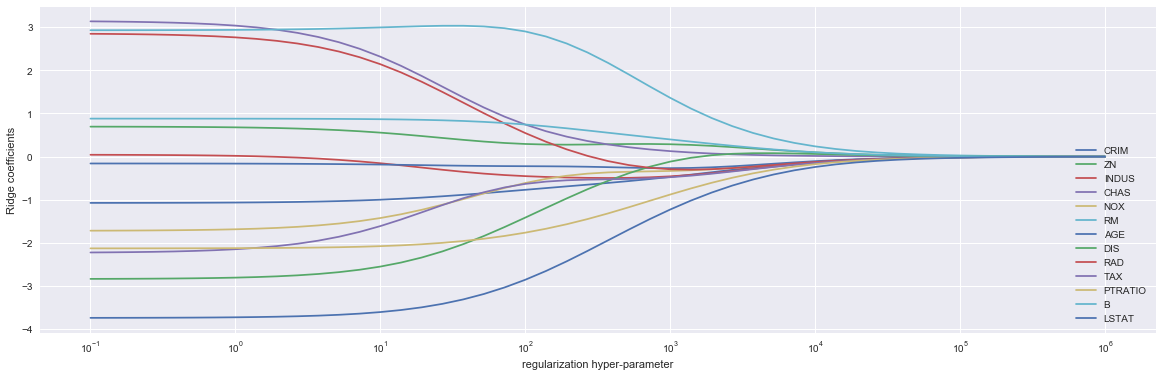

In [14]:
n_alphas = 50
alphas = np.logspace(-1, 6, n_alphas)

rr.plot_coefficients(
    df = df_std, 
    features = features, 
    target = target, 
    linear_model_name = 'Ridge', 
    linear_model_args = {'fit_intercept' :True}, 
    alphas = alphas
)

### <font color='#28B463'>Variance Inflation Factor

<br>

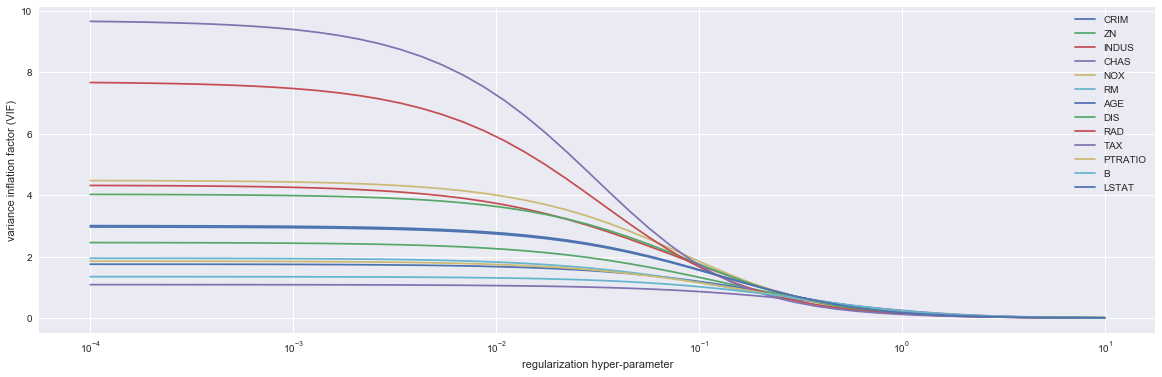

In [15]:
n_alphas = 50
alphas = np.logspace(-4, 1, n_alphas)

rr.plot_vif(df = df_std, features = features, alphas = alphas)

### <font color='#28B463'>Grid-Search Cross Validation

<br>

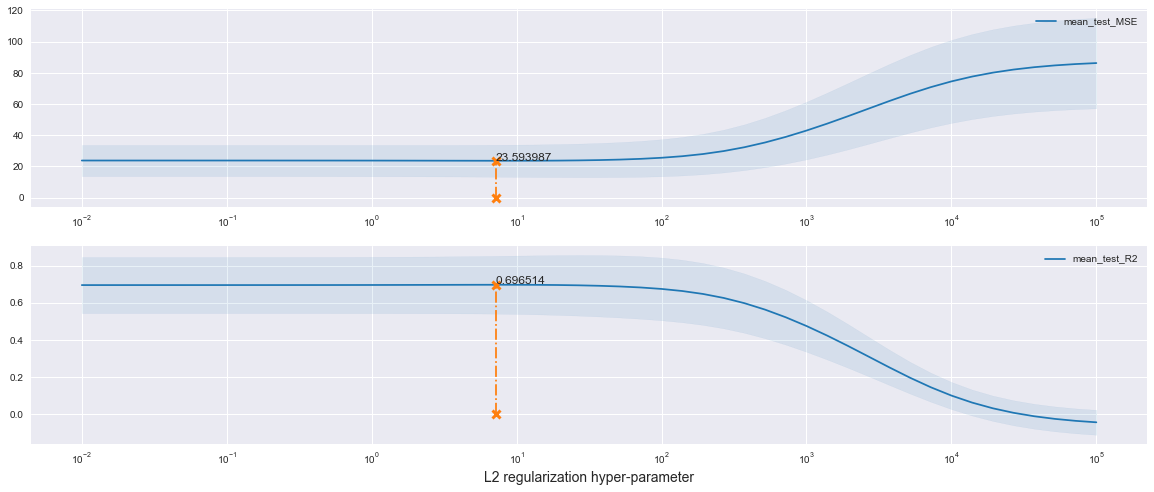

In [16]:
n_alphas = 50
alphas = np.logspace(-2, 5, n_alphas)

scoring_list = {
    'MSE' : 'neg_mean_squared_error', 
    'R2' : 'r2'}

grid = GridSearchCV(
    estimator = lm.Ridge(fit_intercept = True), 
    param_grid = {'alpha' : alphas}, 
    scoring = scoring_list,  
    refit = 'MSE',
    cv = 10
)

grid.fit(df_std[features], df_std[target])
grid_results = grid.cv_results_

rr.plot_gridsearch_cv(
    param_name = 'param_alpha', 
    param = alphas, 
    scoring_list = scoring_list, 
    grid_results = grid_results,
    plot_args = {'xscale' : 'log', 'xlabel' : 'L2 regularization hyper-parameter'}
)


In [17]:
alpha = 10**(2)

ridge_list = [
    { 'df' : df_train,     'linear_model_name' : 'Ridge', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'original' },
    #{ 'df' : df_sk,     'linear_model_name' : 'Ridge', 
    # 'linear_model_args' : {'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'linear_model_name' : 'Ridge', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'centered' },
    { 'df' : df_std, 'linear_model_name' : 'Ridge', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'standardized'}    
]

results_ridge = pd.DataFrame()

for l in ridge_list:
    results_temp = uc.compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        linear_model_name = l['linear_model_name'], 
        linear_model_args = l['linear_model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results_ridge = results_ridge.append(results_temp).reset_index(drop = True)

#print(results_ridge[['note','intercept', 'err_test']])

## <font color='#28B463'>Impact on the intercept

<br>

In [18]:
print(results.columns)

Index(['linear_model_name', 'note', 'iteration', 'intercept', 'coef',
       'residuals', 'res_normality', 'res_homoscedasticity', 'AGE', 'B',
       'CHAS', 'CRIM', 'DIS', 'ESS', 'EVAR', 'FVU', 'INDUS', 'LSTAT', 'MSE',
       'NOX', 'PTRATIO', 'R2', 'RAD', 'RM', 'RSS', 'TAX', 'TSS', 'TVAR',
       'UVAR', 'ZN'],
      dtype='object')


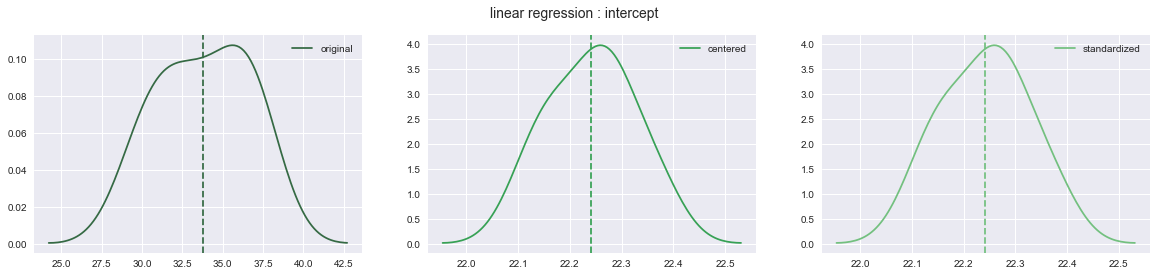

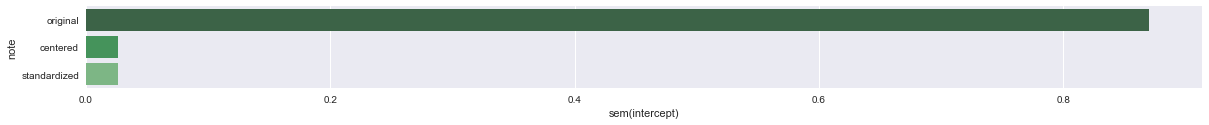

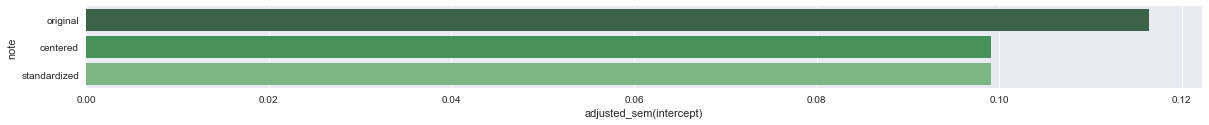

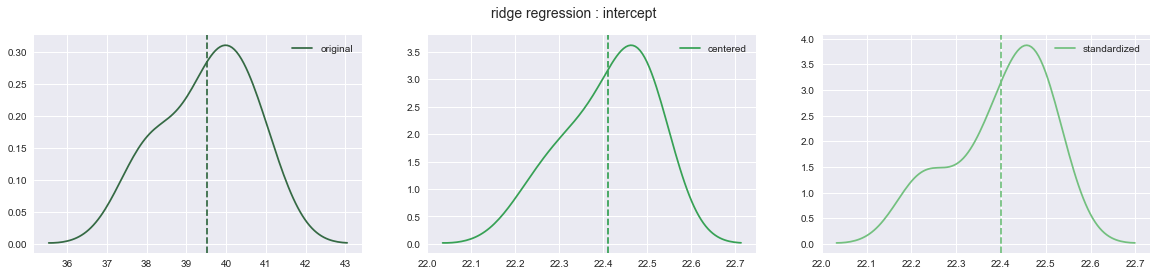

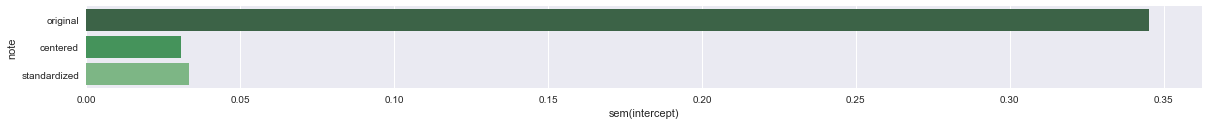

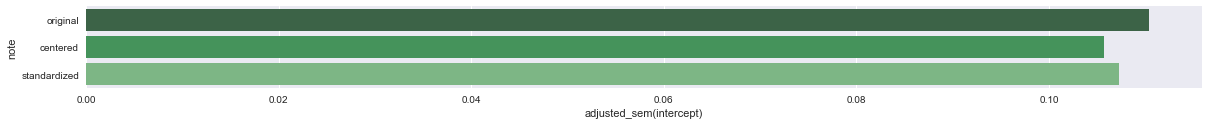

In [19]:
up.plot_across_discriminant(
    df = results, 
    cols = ['intercept'], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

up.plot_across_discriminant(
    df = results_ridge, 
    cols = ['intercept'], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'ridge regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

## <font color='#28B463'>Impact on the regression coefficients of the transformed features

<br>

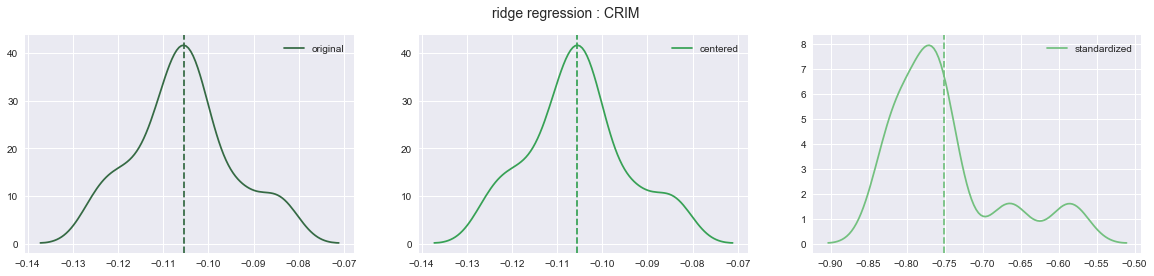

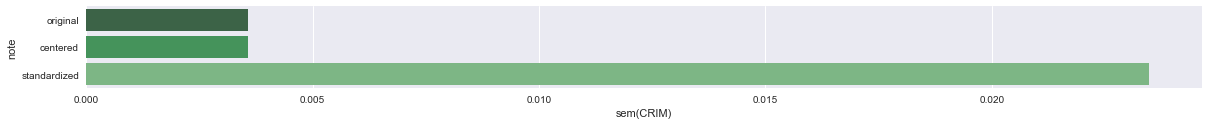

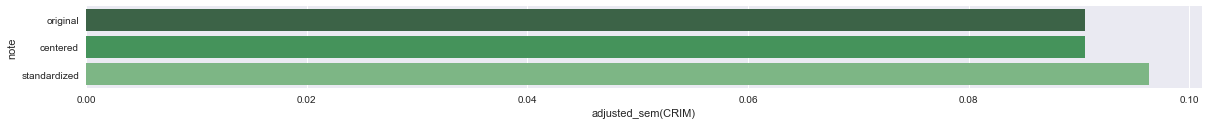

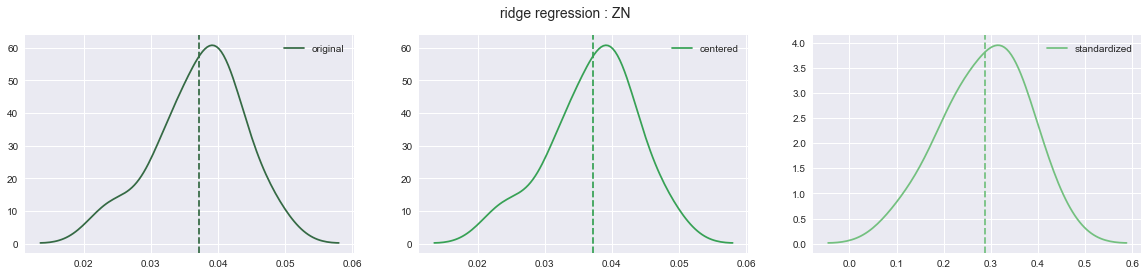

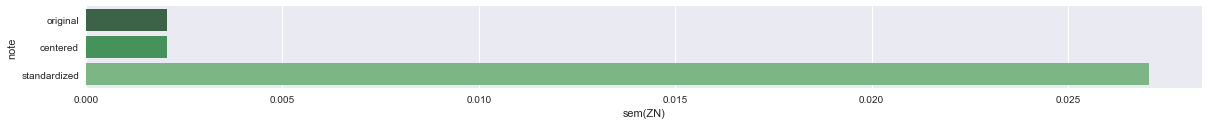

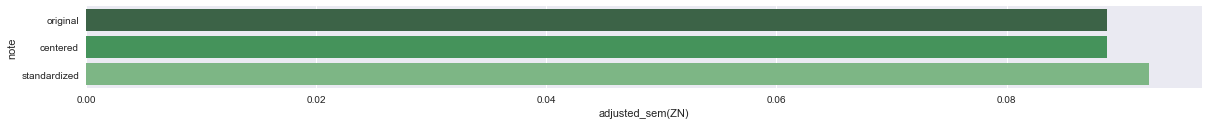

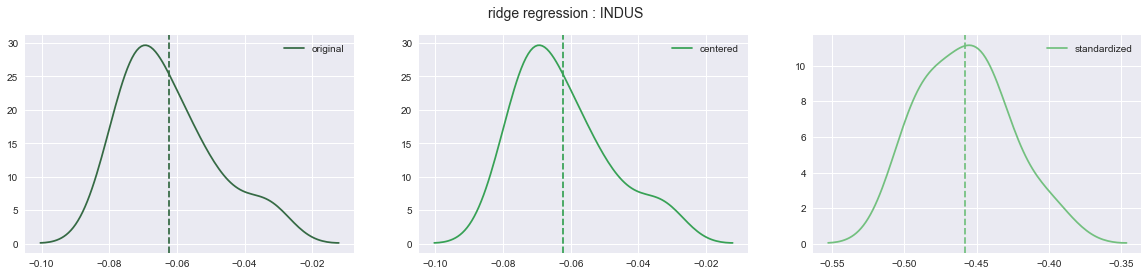

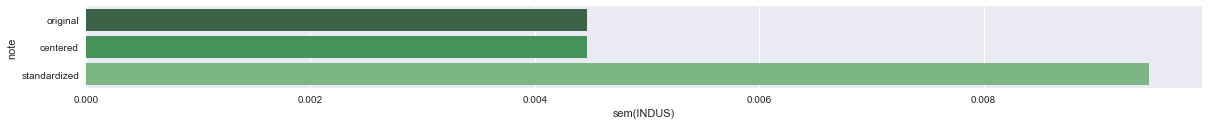

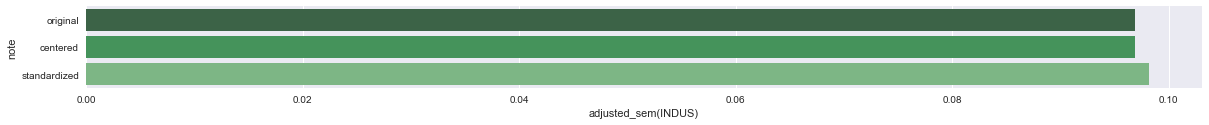

In [20]:
visualized_features = included_features[:3]

up.plot_across_discriminant(
    df = results_ridge, 
    cols = visualized_features, 
    discriminant_col = 'note', 
    plot_args = {'title' : 'ridge regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)    
    

## <font color='#28B463'>Impact on the regression coefficients of the non-transformed features

<br>

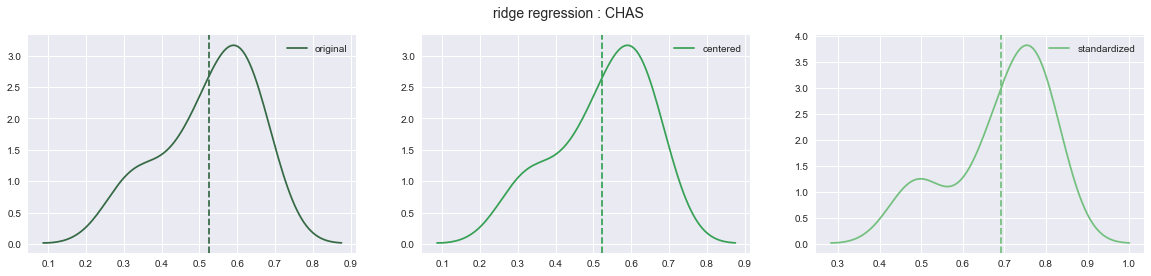

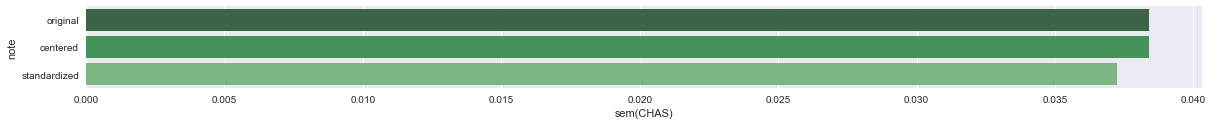

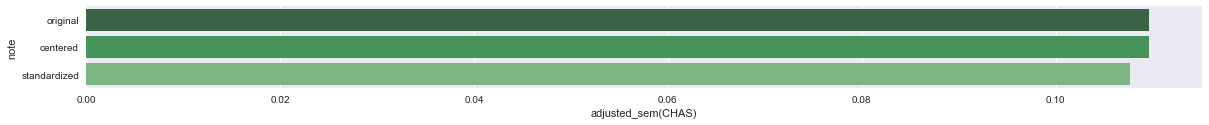

In [21]:
visualized_features = excluded_features

up.plot_across_discriminant(
    df = results_ridge, 
    cols = visualized_features, 
    discriminant_col = 'note', 
    plot_args = {'title' : 'ridge regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

    

## <font color='#28B463'>Impact on the regression score

<br>

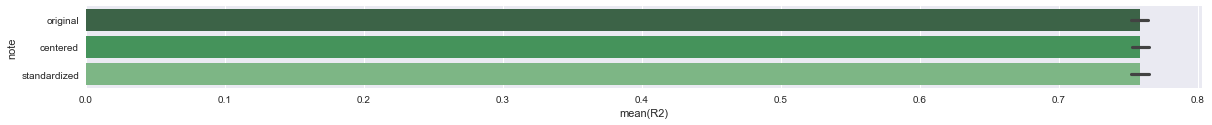

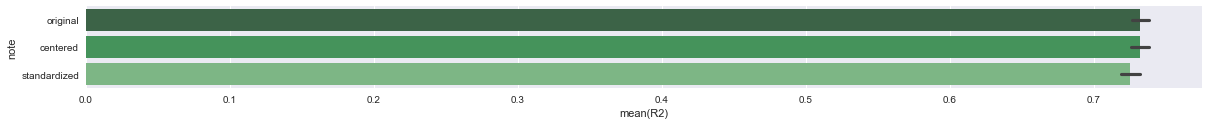

                                            linear regression                                                 ridge regression

R2 mean (original)       :                             0.7581     R2 mean (original)       :                            0.7322
R2 mean (centered)       :                             0.7581     R2 mean (centered)       :                            0.7322
R2 mean (standardized)   :                             0.7581     R2 mean (standardized)   :                            0.7253


In [22]:
metric = 'R2'

up.plot_across_discriminant(
    df = results, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)

up.plot_across_discriminant(
    df = results_ridge, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'ridge regression', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


template = "{0:>61}{1:>65}" 
print(template.format('linear regression', 'ridge regression'))
print()

discriminant_values = results['note'].unique().tolist() 
template = "{0:25}:{1:>35}     {2:25}:{3:34}" 
for (d_index,d) in enumerate(discriminant_values):
    label_1 = ('{0} mean ({1})'.format(metric, d))
    label_2 = ('{0} mean ({1})'.format(metric, d))
    
    criteria = (results_ridge['note'] == d)
    
    subset_1 = results[criteria][metric]    
    subset_2 = results_ridge[criteria][metric]
    
    print(template.format(label_1, round(subset_1.mean(), 4), label_2, round(subset_2.mean(), 4)))


## <font color='#28B463'>Considerations

<br>
In this notebook it has been demonstrated that the ordinary least squares estimate of the regression coefficients suffers from a
number of deficiencies when the design matrix $ \mathbf{X}^{\top}\mathbf{X} \ $ does not have a uniform eigenvalue spectrum. This unsatisfactory condition manifests itself in estimates that are too large in absolute value and some may even have the wrong sign.

<br>
A class of biased estimators $ \ \hat{\boldsymbol{\beta}}_\boldsymbol{R} \ $ (obtained by augmenting the diagonal of the design matrix with small positive quantities) has been introduced both to portray the sensitivity of the solution to the design matrix itself, and to form the basis for obtaining an estimate of the regression coefficients with a smaller mean squared error.

<br>
When all the solutions for the predetermined interval of the regularization parameter are found, it is possible to obtain a two-dimensional characterization of the system and a portrayal of the kinds of issues caused by the multicollinearity among the predictors. 

<br>
A study of the properties of the ridge estimator shows that it can be used to improve the mean squared error of estimation,
and the magnitude of this improvement increases with an increase in the spread of the eigenvalue spectrum.


## <font color='#28B463'>References

<br>
<ul style="list-style-type:square">
    <li>
        Wikipedia - Tikhonov regularization <br>
        https://en.wikipedia.org/wiki/Tikhonov_regularization
    </li>
    <br>
    <li>
         Hoerl and Kennard - Ridge Regression: Biased Estimation for Nonorthogonal Problems <br>
         http://homepages.math.uic.edu/~lreyzin/f16_mcs548/ridge.pdf
    </li>
    <br>
    <li>
        Wessel N. van Wieringen - Lecture notes on ridge regression <br>
        https://arxiv.org/pdf/1509.09169.pdf
    </li>
    <br>
    <li>
        Marquardt and Snee - Ridge_Regression_in_Practice <br>
        http://www.jarad.me/stat615/papers/Ridge_Regression_in_Practice.pdf
    </li>
    <br>
    <li>
        Guy Lebanon - Bias, Variance, and MSE of Estimators <br>
        https://pdfs.semanticscholar.org/205c/483a68e8d58f8ab09c9bee7f82a46e27829d.pdf
    </li>
    <br>
    <li>
        Uslu, Egrioglu, Bas - 
        Finding Optimal Value for the Shrinkage Parameter in Ridge Regression via Particle Swarm Optimization <br>
        http://article.sapub.org/10.5923.j.ajis.20140404.03.html
    </li>
</ul>
